In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/ĐAPM_AI/HandSign
!ls

/content/drive/MyDrive/Colab Notebooks/ĐAPM_AI/HandSign
archive.zip  HandSignVer2.ipynb  model.png  Test.ipynb


## Data_processing

In [ ]:
#Import the libraries
import zipfile
import os
import shutil
import numpy as np
from imutils import paths

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/ĐAPM_AI/HandSign/archive.zip", 'r') #Opens the zip file in read mode
zip_ref.extractall('/dataset') 
zip_ref.close()

In [ ]:
#new path
path_train = "/dataset/asl_alphabet_train/asl_alphabet_train/"
path_test = "/dataset/asl_alphabet_test/asl_alphabet_test/"

In [ ]:
def Folder_split(root_folder, list_labels ):
  for label in list_labels:
    os.makedirs(root_folder + "/train/" + label )  
    os.makedirs(root_folder + "/val/" + label ) 
    os.makedirs(root_folder + "/test/" + label ) 

    src = root_folder + "/" + label

    allPathImages = os.listdir(src)
    np.random.shuffle(allPathImages)

    train_paths, val_paths, test_paths = np.split(np.array(allPathImages), [int(len(allPathImages)*0.7) , int(len(allPathImages)*0.85)])

    train_paths = [src + "/" + name for name in train_paths.tolist()]
    val_paths = [src + "/" + name for name in val_paths.tolist()]
    test_paths = [src + "/" + name for name in test_paths.tolist()]

    for name in train_paths:
      shutil.copy(name, root_folder + "/train/" +  label )
      
    for name in val_paths:
      shutil.copy(name, root_folder + "/val/" +  label )

    for name in test_paths:
      shutil.copy(name, root_folder + "/test/" +  label )

  return root_folder + "/train" , root_folder + "/val" ,root_folder + "/test" 

In [ ]:
root_folder = "/dataset/asl_alphabet_train/asl_alphabet_train"
image_paths = list(paths.list_images(root_folder))


list_labels =  os.listdir(root_folder)
print(len(image_paths))
print((list_labels))

87000
['V', 'E', 'K', 'C', 'del', 'M', 'B', 'F', 'X', 'H', 'O', 'P', 'I', 'nothing', 'Q', 'space', 'U', 'R', 'G', 'D', 'N', 'Y', 'J', 'L', 'S', 'T', 'A', 'W', 'Z']


In [ ]:
# Create train, val, test paths
train_paths, val_paths , test_path = Folder_split(root_folder, list_labels)

## Training with ResNet50 - Pre-Train Model

In [ ]:
#Import the libraries for training
import tensorflow as tf 
from tensorflow import keras
import cv2   
import random
import matplotlib.pyplot as plt  
from keras.models import Sequential
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D,Dropout,Flatten,Dense,MaxPooling2D, BatchNormalization
from sklearn.preprocessing import LabelBinarizer
from keras import layers
from tensorflow.keras.applications import ResNet50

In [ ]:
aug = ImageDataGenerator(rescale=1/255.0)


train_ds = aug.flow_from_directory(train_paths, target_size=(224,224),  class_mode='categorical' ,batch_size=128,shuffle = True)
val_ds =  aug.flow_from_directory(val_paths, target_size=(224,224), class_mode='categorical', batch_size=128 )
test = aug.flow_from_directory(test_path,class_mode="categorical", target_size=(224,224), batch_size=64 )

Found 60900 images belonging to 29 classes.
Found 13050 images belonging to 29 classes.
Found 13050 images belonging to 29 classes.


In [ ]:
batchX, batchy = train_ds.next()
# print(batchX[1])
print(batchy[1])
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchy.min(), batchy.max()))

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
Batch shape=(128, 224, 224, 3), min=0.000, max=1.000


In [ ]:
baseModel = ResNet50(weights="imagenet", include_top= False, input_shape = (224,224,3))
input = baseModel.layers[0].input
output = baseModel.output
fcHead = layers.Flatten()(output)
fcHead = layers.Dense(128)(fcHead)
fcHead = layers.Activation('relu')(fcHead)
fcHead = layers.Dropout(0.5)(fcHead)

fcHead = layers.Dense(29, activation='softmax')(fcHead)
model = keras.Model(inputs=input, outputs=fcHead)


94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
model.compile(loss ="categorical_crossentropy", optimizer ="adam", metrics = ["accuracy"])
# EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
H = model.fit(train_ds, validation_data = val_ds, epochs= 5)

Epoch 1/5
476/476 [==============================] - 665s 1s/step - loss: 0.2292 - accuracy: 0.9405 - val_loss: 69.8378 - val_accuracy: 0.0345
Epoch 2/5
476/476 [==============================] - 650s 1s/step - loss: 0.0483 - accuracy: 0.9885 - val_loss: 1.2784 - val_accuracy: 0.8243
Epoch 3/5
476/476 [==============================] - 651s 1s/step - loss: 0.0340 - accuracy: 0.9916 - val_loss: 0.0731 - val_accuracy: 0.9813
Epoch 4/5
476/476 [==============================] - 648s 1s/step - loss: 0.0202 - accuracy: 0.9949 - val_loss: 0.0410 - val_accuracy: 0.9900
Epoch 5/5
476/476 [==============================] - 650s 1s/step - loss: 0.0235 - accuracy: 0.9947 - val_loss: 0.0091 - val_accuracy: 0.9971


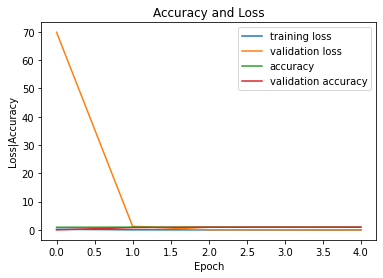

In [ ]:
fig = plt.figure()
numOfEpoch = 5
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H.history['accuracy'], label='accuracy')
plt.plot(np.arange(0, numOfEpoch), H.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/ĐAPM_AI/HandSign/ASL_ResNet50.h5')

In [ ]:
import math

number_of_examples = len(test.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 64)) 
# 1.0 above is to skip integer division

test_labels = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(test[i][1]))

print(test_labels[1])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]


0


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

+ precision = 0.996
+ recall = 0.996
+ f1_score = 0.996


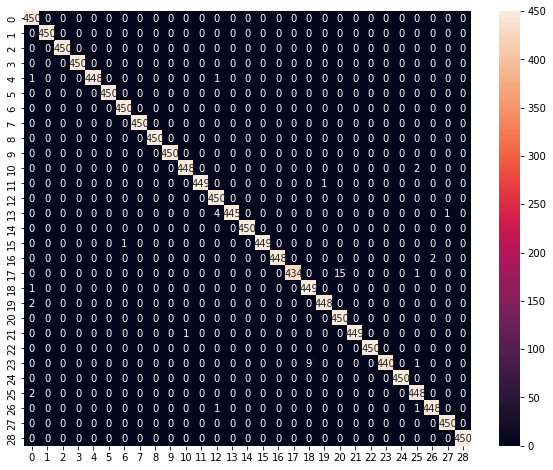

In [ ]:
Y_pred = model.predict(test)
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.argmax(test_labels, axis=1)
a = precision_recall_fscore_support(y_true, y_pred, average='macro')
cf = confusion_matrix(y_true,y_pred)



print(f'+ precision = {a[0]:.3f}')
print(f'+ recall = {a[1]:.3f}')
print(f'+ f1_score = {a[2]:.3f}')
plt.figure(figsize = (10,8))
ax = sns.heatmap(data=cf ,fmt="d",annot = True)
plt.show()

In [ ]:
# model =  tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ĐAPM_AI/HandSign/ASL_ResNet50.h5")

Actual class: I 
 Predicted class: I


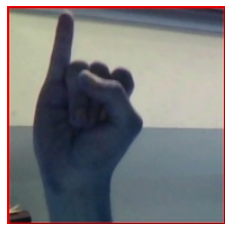

Actual class: T 
 Predicted class: T


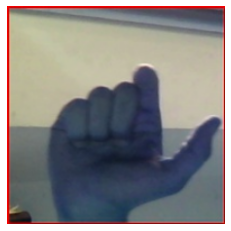

Actual class: V 
 Predicted class: V


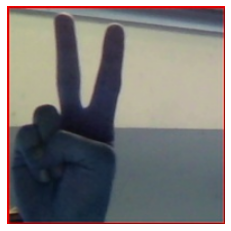

Actual class: S 
 Predicted class: S


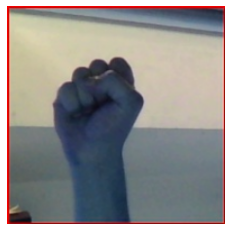

Actual class: G 
 Predicted class: G


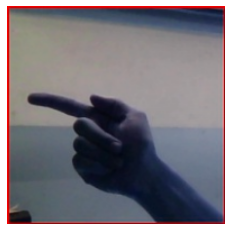

Actual class: A 
 Predicted class: A


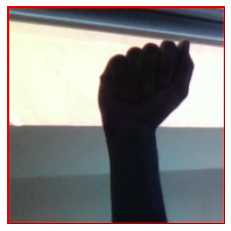

Actual class: U 
 Predicted class: U


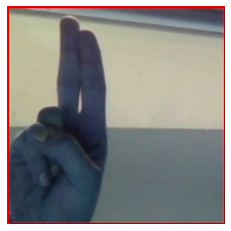

Actual class: C 
 Predicted class: C


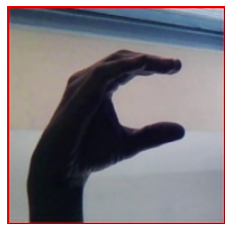

Actual class: X 
 Predicted class: X


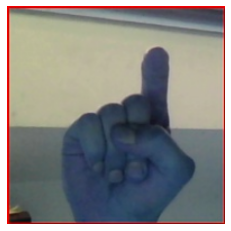

Actual class: O 
 Predicted class: O


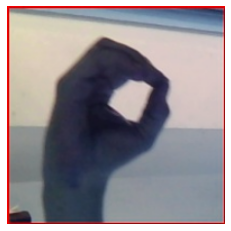

Actual class: H 
 Predicted class: H


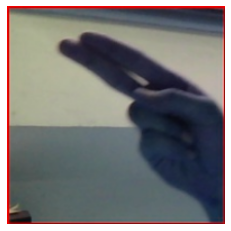

Actual class: L 
 Predicted class: L


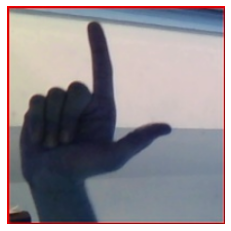

Actual class: space 
 Predicted class: space


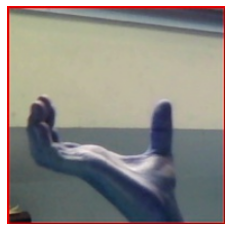

Actual class: J 
 Predicted class: J


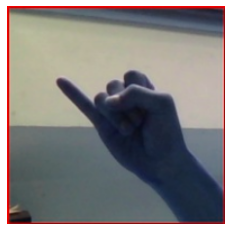

Actual class: Z 
 Predicted class: Z


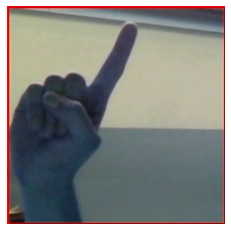

Actual class: E 
 Predicted class: E


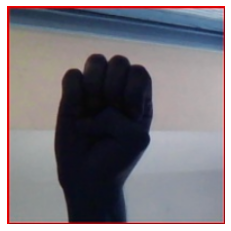

Actual class: F 
 Predicted class: F


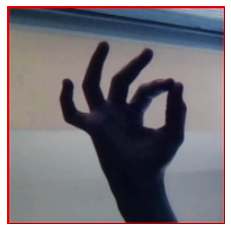

Actual class: M 
 Predicted class: M


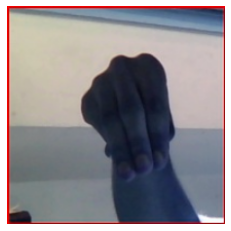

Actual class: N 
 Predicted class: N


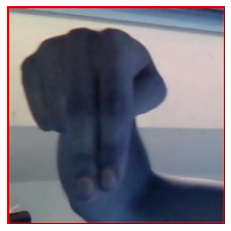

Actual class: nothing 
 Predicted class: nothing


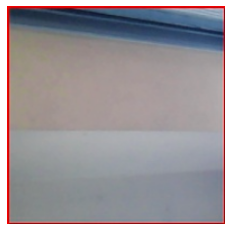

Actual class: K 
 Predicted class: K


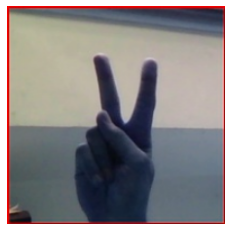

Actual class: P 
 Predicted class: P


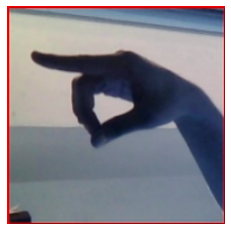

Actual class: Q 
 Predicted class: Q


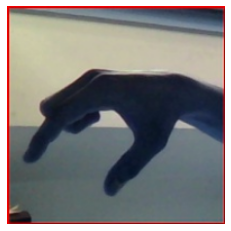

Actual class: R 
 Predicted class: R


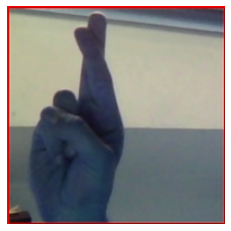

Actual class: W 
 Predicted class: W


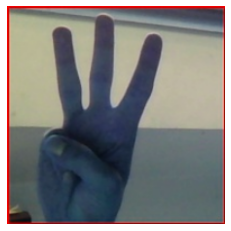

Actual class: Y 
 Predicted class: Y


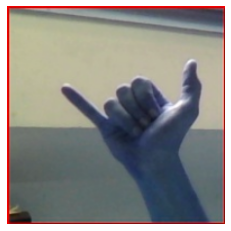

Actual class: B 
 Predicted class: B


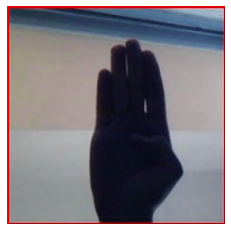

Actual class: D 
 Predicted class: D


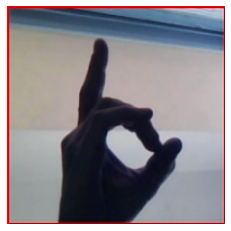

In [ ]:

classes = os.listdir(path_train)
classes.sort()

for i, test_image in enumerate(os.listdir(path_test)):
    image_location = path_test + test_image
    img = cv2.imread(image_location)
    img = cv2.resize(img, (224, 224))
    plt.figure()
    plt.axis('Off')
    plt.imshow(img)
    img = np.array(img) / 255.
    img = img.reshape((1, 224, 224, 3))
    prediction = np.array(model.predict(img))
    actual = test_image.split('_')[0]
    predicted = classes[prediction.argmax()]
    print('Actual class: {} \n Predicted class: {}'.format(actual, predicted))
    plt.show()